In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../data/10am_rowdata.csv')
df

,date_only,future_10,future_2,future_9,index_10,index_2,index_9
0,2023-05-18,15971,16070,16026,16065.42,16101.88,16060.26
1,2023-05-19,16120,16129,16153,16137.67,16174.92,16146.29
2,2023-05-22,16120,16116,16133,16162.27,16180.89,16168.74
3,2023-05-23,16105,16133,16149,16169.85,16188.03,16186.15
4,2023-05-24,16071,16072,16055,16119.42,16159.32,16186.62
...,...,...,...,...,...,...,...
121,2023-11-13,16892,16876,16969,16877.70,16839.29,16711.53
122,2023-11-14,16948,16949,16956,16921.55,16915.71,16884.52
123,2023-11-15,17119,17123,17170,17109.41,17128.78,17039.62
124,2023-11-16,17171,17186,17196,17120.89,17171.18,17136.52


In [3]:
# Sort data by date
df = df.sort_values(by='date_only')

# Drop 'date' column for now
df = df.drop(['date_only'], axis=1)
df

,future_10,future_2,future_9,index_10,index_2,index_9
0,15971,16070,16026,16065.42,16101.88,16060.26
1,16120,16129,16153,16137.67,16174.92,16146.29
2,16120,16116,16133,16162.27,16180.89,16168.74
3,16105,16133,16149,16169.85,16188.03,16186.15
4,16071,16072,16055,16119.42,16159.32,16186.62
...,...,...,...,...,...,...
121,16892,16876,16969,16877.70,16839.29,16711.53
122,16948,16949,16956,16921.55,16915.71,16884.52
123,17119,17123,17170,17109.41,17128.78,17039.62
124,17171,17186,17196,17120.89,17171.18,17136.52


In [4]:
# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
scaled_data

array([[0.        , 0.05658972, 0.        , 0.02062079, 0.07543619,
        0.02427199],
       [0.10612536, 0.10052122, 0.09243086, 0.07462051, 0.13020072,
        0.08844283],
       [0.10612536, 0.0908414 , 0.07787482, 0.09300657, 0.13467695,
        0.10518857],
       [0.0954416 , 0.10349963, 0.08951965, 0.09867187, 0.14003044,
        0.1181749 ],
       [0.07122507, 0.05807893, 0.02110626, 0.06098044, 0.11850402,
        0.11852548],
       [0.12962963, 0.15860015, 0.07714702, 0.16901724, 0.21798592,
        0.10161565],
       [0.3034188 , 0.32836932, 0.24454148, 0.36252681, 0.37772829,
        0.35909715],
       [0.43019943, 0.42889054, 0.42285298, 0.45867994, 0.47613799,
        0.43497136],
       [0.43233618, 0.43335815, 0.38136827, 0.44660194, 0.46597086,
        0.4632489 ],
       [0.40527066, 0.36857781, 0.40029112, 0.39668303, 0.43314514,
        0.4220447 ],
       [0.33404558, 0.35443038, 0.30131004, 0.34976121, 0.38342668,
        0.36048454],
       [0.47435897, 0

In [5]:
from joblib import dump

dump(scaler, 'gru_scaler.joblib')

['gru_scaler.joblib']

In [6]:
# Initialize X and y using the scaled data
X, y = [], []

idx_index_2pm = df.columns.get_loc('index_2')
idx_index_9am = df.columns.get_loc('index_9')
idx_index_10am = df.columns.get_loc('index_10')
idx_future_2pm = df.columns.get_loc('future_2')
idx_future_9am = df.columns.get_loc('future_9')
idx_future_10am = df.columns.get_loc('future_10')


for i in range(1, len(scaled_data)):
    X.append([
        scaled_data[i-2, idx_index_2pm],     # 2 days ago's index 2pm
        scaled_data[i-2, idx_future_2pm],    # 2 days ago's future 2pm
        scaled_data[i-1, idx_index_2pm],     # yesterday's index 2pm
        scaled_data[i-1, idx_future_2pm],    # yesterday's future 2pm
        scaled_data[i, idx_index_9am],       # today's index 9am
        scaled_data[i, idx_future_9am],      # today's future 9am
        scaled_data[i, idx_index_10am],      # today's index 10am
        scaled_data[i, idx_future_10am]      # today's future 10am
    ])
    y.append(scaled_data[i, idx_index_2pm])

X

[[0.9055041950648945,
  0.914370811615786,
  0.07543618927652851,
  0.0565897244973943,
  0.08844283327366043,
  0.092430858806404,
  0.07462050718626045,
  0.10612535612535723],
 [0.07543618927652851,
  0.0565897244973943,
  0.1302007182970808,
  0.10052122114668727,
  0.10518856665473209,
  0.07787481804949081,
  0.09300656965402787,
  0.10612535612535723],
 [0.1302007182970808,
  0.10052122114668727,
  0.134676953760561,
  0.09084139985107953,
  0.11817490153956278,
  0.08951965065502243,
  0.09867186857702315,
  0.0954415954415957],
 [0.134676953760561,
  0.09084139985107953,
  0.14003044140030418,
  0.10349962769918086,
  0.1185254803675857,
  0.02110625909752528,
  0.060980440518099144,
  0.07122507122507216],
 [0.14003044140030418,
  0.10349962769918086,
  0.11850402261361026,
  0.0580789277736411,
  0.10161564625850339,
  0.07714701601164542,
  0.1690172425390699,
  0.12962962962962976],
 [0.11850402261361026,
  0.0580789277736411,
  0.2179859189778881,
  0.15860014892032837,
 

In [7]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Create the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(8, 1)))
model.add(GRU(units=50, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
4/4 [==============================] - 3s 8ms/step - loss: 0.3169
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1241
Epoch 3/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0239
Epoch 4/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0238
Epoch 5/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0297
Epoch 6/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 7/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0114
Epoch 8/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0141
Epoch 9/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0112
Epoch 10/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0080
Epoch 11/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0077
Epoch 12/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0076
Epoch 13/100
4/4 [==============================] - 0s 7ms/st

In [10]:
X_test[0]

[0.7153729071537285,
 0.7058823529411757,
 0.9112400746789024,
 0.9128816083395375,
 0.8674812030075181,
 0.8537117903930138,
 0.9027631411765604,
 0.8732193732193743]

In [11]:
len(X_test)

25

In [12]:
# Prediction and performance check
predict_index = model.predict(X_test)


1/1 [==============================] - 1s 644ms/step


In [13]:
y_test_array = np.array(y_test)
dummy_array = np.zeros((len(y_test_array), 6))
dummy_array[:, 0] = y_test_array

y_test_inverse_transformed = scaler.inverse_transform(dummy_array)
y_test_origin = y_test_inverse_transformed[:, 0]
y_test_origin

array([17273.0562791 , 17195.94581281, 16982.39456104, 16621.43336258,
       17018.15486875, 16342.04608948, 16637.81341521, 17202.56731223,
       16447.9479722 , 16277.05223024, 16961.62473851, 16690.71172144,
       17057.74701397, 16517.66846616, 17375.        , 16576.04082597,
       16713.82907079, 16646.07713071, 16721.74539443, 16504.06754842,
       17276.93022471, 16425.43066334, 16153.80180849, 16954.60321209,
       17081.76968756])

In [14]:
predict_array = np.array(predict_index)
dummy_array_predict = np.zeros((len(predict_array), 6))
dummy_array_predict[:, 0] = predict_index.ravel()

predict_inverse_transformed = scaler.inverse_transform(dummy_array_predict)
predict_origin = predict_inverse_transformed[:, 0]
predict_origin

array([17251.72056246, 17158.25479865, 16933.73175335, 16669.85457671,
       16930.67934585, 16369.31177235, 16706.35095167, 17191.98124456,
       16558.60794294, 16180.38958967, 16970.81706095, 16690.79543114,
       17010.76071072, 16525.944965  , 17311.2975316 , 16529.88811481,
       16645.84503806, 16760.59668922, 16771.46526837, 16497.60933435,
       17249.58525801, 16519.70842993, 16115.93597588, 16885.85937572,
       17123.73652601])

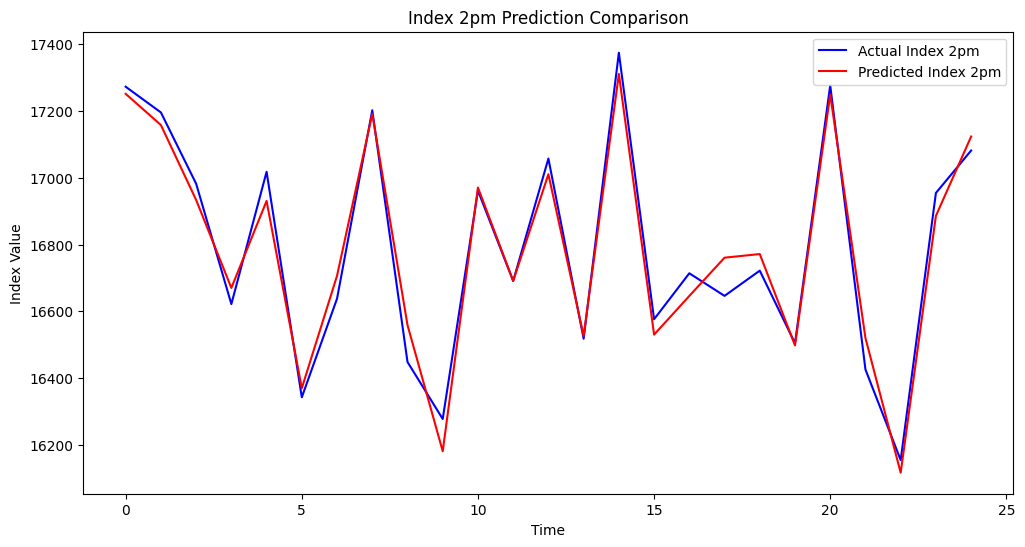

In [15]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test_origin, color='blue', label='Actual Index 2pm')
plt.plot(predict_origin, color='red', label='Predicted Index 2pm')
plt.title('Index 2pm Prediction Comparison')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.legend()
plt.show()

In [16]:
model.save("GRU_10am.h5")

c:\Users\overf\anaconda3\envs\StockMarketIndexAI\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
predict_index_full = model.predict(X)

4/4 [==============================] - 0s 3ms/step


In [18]:
predict_array_full = np.array(predict_index_full)
dummy_array_full = np.zeros((len(predict_array_full), 6))
dummy_array_full[:, 0] = predict_array_full.ravel()
predict_inverse_transformed_full = scaler.inverse_transform(dummy_array_full)
predict_origin_full = predict_inverse_transformed_full[:, 0]

In [19]:
predictions = np.concatenate([[np.nan], predict_origin_full])  # Prepend NaN for the first row

In [20]:
df['Predicted_Index_2pm'] = predictions
df

,future_10,future_2,future_9,index_10,index_2,index_9,Predicted_Index_2pm
0,15971,16070,16026,16065.42,16101.88,16060.26,NaN
1,16120,16129,16153,16137.67,16174.92,16146.29,16115.935976
2,16120,16116,16133,16162.27,16180.89,16168.74,16144.418160
3,16105,16133,16149,16169.85,16188.03,16186.15,16148.147903
4,16071,16072,16055,16119.42,16159.32,16186.62,16101.571585
...,...,...,...,...,...,...,...
121,16892,16876,16969,16877.70,16839.29,16711.53,16916.903050
122,16948,16949,16956,16921.55,16915.71,16884.52,16971.088870
123,17119,17123,17170,17109.41,17128.78,17039.62,17157.930436
124,17171,17186,17196,17120.89,17171.18,17136.52,17191.981245


In [22]:
df.to_csv('../data/GRU_full_predictions.csv', index=False)